In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [4]:
# Import necessary libraries
import psycopg2
import pandas as pd

# Define the connection parameters
host = 'localhost'        
port = '5432'             # Default PostgreSQL port
dbname = 'telecom_db'  
user = 'postgres'        
password = 'neba'  

# Establish the connection
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)

In [5]:
# Define the SQL query to aggregate engagement metrics per customer (MSISDN)
query = """
SELECT 
    "MSISDN/Number" AS customer_id,
    COUNT("Bearer Id") AS session_frequency,
    SUM("Dur. (ms)") AS total_duration,
    SUM("Total DL (Bytes)") + SUM("Total UL (Bytes)") AS total_traffic
FROM 
    xdr_data
GROUP BY 
    "MSISDN/Number"
ORDER BY 
    session_frequency DESC
"""

# Load the aggregated data into a DataFrame
engagement_df = pd.read_sql(query, conn)

# Display the first few rows of the aggregated data
engagement_df.head()

C:\Users\neba\AppData\Local\Temp\ipykernel_13440\3277734267.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  engagement_df = pd.read_sql(query, conn)


,customer_id,session_frequency,total_duration,total_traffic
0,NaN,504,72446396.0,5.312489e+11
1,3.362632e+10,18,8791927.0,7.971167e+09
2,3.361489e+10,17,9966898.0,8.846226e+09
3,3.362578e+10,17,18553754.0,8.499621e+09
4,3.365973e+10,16,4035428.0,7.705863e+09


In [6]:
# Normalize the metrics using StandardScaler
scaler = StandardScaler()
engagement_df_scaled = scaler.fit_transform(engagement_df[['session_frequency', 'total_duration', 'total_traffic']])

# Perform K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_df['engagement_cluster'] = kmeans.fit_predict(engagement_df_scaled)

# Display the first few rows with cluster assignments
engagement_df.head()

c:\Users\neba\Documents\telecom_analysis\env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\neba\Documents\telecom_analysis\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\neba\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\neba\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\neba\Ap

,customer_id,session_frequency,total_duration,total_traffic,engagement_cluster
0,NaN,504,72446396.0,5.312489e+11,1
1,3.362632e+10,18,8791927.0,7.971167e+09,2
2,3.361489e+10,17,9966898.0,8.846226e+09,2
3,3.362578e+10,17,18553754.0,8.499621e+09,2
4,3.365973e+10,16,4035428.0,7.705863e+09,2


In [8]:
# Compute the minimum, maximum, average, and total non-normalized metrics for each cluster
cluster_summary = engagement_df.groupby('engagement_cluster')[['session_frequency', 'total_duration', 'total_traffic']].agg(
    min_value=('session_frequency', 'min'),
    max_value=('session_frequency', 'max'),
    average_value=('session_frequency', 'mean'),
    total_value=('session_frequency', 'sum')
).reset_index()

# Repeat the same for 'total_duration' and 'total_traffic'
cluster_summary_duration = engagement_df.groupby('engagement_cluster')[['session_frequency', 'total_duration', 'total_traffic']].agg(
    min_value=('total_duration', 'min'),
    max_value=('total_duration', 'max'),
    average_value=('total_duration', 'mean'),
    total_value=('total_duration', 'sum')
).reset_index()

cluster_summary_traffic = engagement_df.groupby('engagement_cluster')[['session_frequency', 'total_duration', 'total_traffic']].agg(
    min_value=('total_traffic', 'min'),
    max_value=('total_traffic', 'max'),
    average_value=('total_traffic', 'mean'),
    total_value=('total_traffic', 'sum')
).reset_index()

# Combine all summaries into one DataFrame
cluster_summary_all = pd.merge(cluster_summary, cluster_summary_duration, on='engagement_cluster', suffixes=('_session', '_duration'))
cluster_summary_all = pd.merge(cluster_summary_all, cluster_summary_traffic, on='engagement_cluster', suffixes=('', '_traffic'))

# Display the cluster summary
cluster_summary_all

,engagement_cluster,min_value_session,max_value_session,average_value_session,total_value_session,min_value_duration,max_value_duration,average_value_duration,total_value_duration,min_value,max_value,average_value,total_value
0,0,0,3,1.203170,117297,7142.0,581388.0,1.144149e+05,1.115431e+10,3.324901e+07,2.069444e+09,5.963372e+08,5.813692e+13
1,1,504,504,504.000000,504,72446396.0,72446396.0,7.244640e+07,7.244640e+07,5.312489e+11,5.312489e+11,5.312489e+11,5.312489e+11
2,2,1,18,3.332159,31209,46896.0,18553754.0,4.766737e+05,4.464526e+09,5.714004e+07,8.846226e+09,1.675905e+09,1.569653e+13


In [9]:
# Compute the minimum, maximum, average, and total non-normalized metrics for each cluster
cluster_summary = engagement_df.groupby('engagement_cluster')[['session_frequency', 'total_duration', 'total_traffic']].agg(
    min_value=('session_frequency', 'min'),
    max_value=('session_frequency', 'max'),
    average_value=('session_frequency', 'mean'),
    total_value=('session_frequency', 'sum')
).reset_index()

# Repeat the same for 'total_duration' and 'total_traffic'
cluster_summary_duration = engagement_df.groupby('engagement_cluster')[['session_frequency', 'total_duration', 'total_traffic']].agg(
    min_value=('total_duration', 'min'),
    max_value=('total_duration', 'max'),
    average_value=('total_duration', 'mean'),
    total_value=('total_duration', 'sum')
).reset_index()

cluster_summary_traffic = engagement_df.groupby('engagement_cluster')[['session_frequency', 'total_duration', 'total_traffic']].agg(
    min_value=('total_traffic', 'min'),
    max_value=('total_traffic', 'max'),
    average_value=('total_traffic', 'mean'),
    total_value=('total_traffic', 'sum')
).reset_index()

# Combine all summaries into one DataFrame
cluster_summary_all = pd.merge(cluster_summary, cluster_summary_duration, on='engagement_cluster', suffixes=('_session', '_duration'))
cluster_summary_all = pd.merge(cluster_summary_all, cluster_summary_traffic, on='engagement_cluster', suffixes=('', '_traffic'))

# Display the cluster summary
cluster_summary_all

,engagement_cluster,min_value_session,max_value_session,average_value_session,total_value_session,min_value_duration,max_value_duration,average_value_duration,total_value_duration,min_value,max_value,average_value,total_value
0,0,0,3,1.203170,117297,7142.0,581388.0,1.144149e+05,1.115431e+10,3.324901e+07,2.069444e+09,5.963372e+08,5.813692e+13
1,1,504,504,504.000000,504,72446396.0,72446396.0,7.244640e+07,7.244640e+07,5.312489e+11,5.312489e+11,5.312489e+11,5.312489e+11
2,2,1,18,3.332159,31209,46896.0,18553754.0,4.766737e+05,4.464526e+09,5.714004e+07,8.846226e+09,1.675905e+09,1.569653e+13


In [11]:
import psycopg2
import pandas as pd

# Define the connection parameters
host = 'localhost'        
port = '5432'             # Default PostgreSQL port
dbname = 'telecom_db'  
user = 'postgres'        
password = 'neba'  

# Establish the connection
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)

# Query to fetch the data
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load the data into a pandas DataFrame
df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Check the first few rows of the dataframe
print(df.head())

C:\Users\neba\AppData\Local\Temp\ipykernel_13440\851208681.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

In [13]:
# Assuming 'df' contains the necessary columns for the applications traffic data
# Create a new DataFrame containing only the application-related traffic columns

app_traffic_df = df[['MSISDN/Number', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)', 
                     'Google DL (Bytes)', 'Google UL (Bytes)', 
                     'Email DL (Bytes)', 'Email UL (Bytes)', 
                     'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 
                     'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 
                     'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 
                     'Other DL (Bytes)', 'Other UL (Bytes)']]

# Check the first few rows to confirm the new DataFrame
print(app_traffic_df.head())

   MSISDN/Number  Social Media DL (Bytes)  Social Media UL (Bytes)  \
0   3.366496e+10                1545765.0                  24420.0   
1   3.368185e+10                1926113.0                   7165.0   
2   3.376063e+10                1684053.0                  42224.0   
3   3.375034e+10                 644121.0                  13372.0   
4   3.369980e+10                 862600.0                  50188.0   

   Google DL (Bytes)  Google UL (Bytes)  Email DL (Bytes)  Email UL (Bytes)  \
0          1634479.0          1271433.0         3563542.0          137762.0   
1          3493924.0           920172.0          629046.0          308339.0   
2          8535055.0          1694064.0         2690151.0          672973.0   
3          9023734.0          2788027.0         1439754.0          631229.0   
4          6248284.0          1500559.0         1936496.0          173853.0   

   Youtube DL (Bytes)  Youtube UL (Bytes)  Netflix DL (Bytes)  \
0          15854611.0           2501332

In [14]:
# Calculate the total download and upload traffic per application
app_traffic_df['Total Social Media Traffic'] = app_traffic_df['Social Media DL (Bytes)'] + app_traffic_df['Social Media UL (Bytes)']
app_traffic_df['Total Google Traffic'] = app_traffic_df['Google DL (Bytes)'] + app_traffic_df['Google UL (Bytes)']
app_traffic_df['Total Email Traffic'] = app_traffic_df['Email DL (Bytes)'] + app_traffic_df['Email UL (Bytes)']
app_traffic_df['Total YouTube Traffic'] = app_traffic_df['Youtube DL (Bytes)'] + app_traffic_df['Youtube UL (Bytes)']
app_traffic_df['Total Netflix Traffic'] = app_traffic_df['Netflix DL (Bytes)'] + app_traffic_df['Netflix UL (Bytes)']
app_traffic_df['Total Gaming Traffic'] = app_traffic_df['Gaming DL (Bytes)'] + app_traffic_df['Gaming UL (Bytes)']
app_traffic_df['Total Other Traffic'] = app_traffic_df['Other DL (Bytes)'] + app_traffic_df['Other UL (Bytes)']

# Check the updated DataFrame
print(app_traffic_df.head())

   MSISDN/Number  Social Media DL (Bytes)  Social Media UL (Bytes)  \
0   3.366496e+10                1545765.0                  24420.0   
1   3.368185e+10                1926113.0                   7165.0   
2   3.376063e+10                1684053.0                  42224.0   
3   3.375034e+10                 644121.0                  13372.0   
4   3.369980e+10                 862600.0                  50188.0   

   Google DL (Bytes)  Google UL (Bytes)  Email DL (Bytes)  Email UL (Bytes)  \
0          1634479.0          1271433.0         3563542.0          137762.0   
1          3493924.0           920172.0          629046.0          308339.0   
2          8535055.0          1694064.0         2690151.0          672973.0   
3          9023734.0          2788027.0         1439754.0          631229.0   
4          6248284.0          1500559.0         1936496.0          173853.0   

   Youtube DL (Bytes)  Youtube UL (Bytes)  Netflix DL (Bytes)  ...  \
0          15854611.0           25

C:\Users\neba\AppData\Local\Temp\ipykernel_13440\1781687528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_traffic_df['Total Social Media Traffic'] = app_traffic_df['Social Media DL (Bytes)'] + app_traffic_df['Social Media UL (Bytes)']
C:\Users\neba\AppData\Local\Temp\ipykernel_13440\1781687528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_traffic_df['Total Google Traffic'] = app_traffic_df['Google DL (Bytes)'] + app_traffic_df['Google UL (Bytes)']
C:\Users\neba\AppData\Local\Temp\ipykern

In [15]:
# Aggregate the engagement metrics per customer (MSISDN)
engagement_metrics = df.groupby('MSISDN/Number').agg(
    sessions_frequency=('Bearer Id', 'nunique'),  # Count unique sessions
    total_session_duration=('Dur. (ms)', 'sum'),  # Sum of session duration
    total_download_traffic=('Total DL (Bytes)', 'sum'),  # Sum of total download traffic
    total_upload_traffic=('Total UL (Bytes)', 'sum')  # Sum of total upload traffic
).reset_index()

# Check the top 10 customers per engagement metric
top_10_sessions_frequency = engagement_metrics.nlargest(10, 'sessions_frequency')
top_10_session_duration = engagement_metrics.nlargest(10, 'total_session_duration')
top_10_download_traffic = engagement_metrics.nlargest(10, 'total_download_traffic')
top_10_upload_traffic = engagement_metrics.nlargest(10, 'total_upload_traffic')

# Display the results
print("Top 10 Customers by Sessions Frequency:")
print(top_10_sessions_frequency)
print("\nTop 10 Customers by Total Session Duration:")
print(top_10_session_duration)
print("\nTop 10 Customers by Total Download Traffic:")
print(top_10_download_traffic)
print("\nTop 10 Customers by Total Upload Traffic:")
print(top_10_upload_traffic)

Top 10 Customers by Sessions Frequency:
       MSISDN/Number  sessions_frequency  total_session_duration  \
13526   3.362632e+10                  18               8791927.0   
6437    3.361489e+10                  17               9966898.0   
13180   3.362578e+10                  17              18553754.0   
37052   3.365973e+10                  16               4035428.0   
76363   3.367588e+10                  15               4865947.0   
92923   3.376054e+10                  15               9279434.0   
65118   3.366716e+10                  13               8744914.0   
666     3.360313e+10                  12               6287761.0   
1279    3.360452e+10                  12               5207990.0   
13994   3.362708e+10                  12               4703516.0   

       total_download_traffic  total_upload_traffic  
13526            7.301517e+09           669650721.0  
6437             8.156743e+09           689483001.0  
13180            7.770043e+09           729577380

In [16]:
from sklearn.preprocessing import StandardScaler

# Select the metrics to normalize
metrics_to_normalize = ['sessions_frequency', 'total_session_duration', 'total_download_traffic', 'total_upload_traffic']

# Initialize the scaler
scaler = StandardScaler()

# Normalize the metrics
engagement_metrics[metrics_to_normalize] = scaler.fit_transform(engagement_metrics[metrics_to_normalize])

# Check the normalized data
print(engagement_metrics.head())

   MSISDN/Number  sessions_frequency  total_session_duration  \
0   3.360100e+10           -0.481513               -0.158014   
1   3.360100e+10           -0.481513                0.188148   
2   3.360100e+10           -0.481513               -0.060090   
3   3.360101e+10           -0.481513               -0.516690   
4   3.360101e+10            0.799294               -0.585235   

   total_download_traffic  total_upload_traffic  
0                0.449862             -0.596125  
1               -1.104067             -0.594685  
2               -0.165736             -0.504876  
3               -0.498672             -1.037143  
4                1.570279              1.036840  


In [17]:
from sklearn.cluster import KMeans

# Initialize KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model
engagement_metrics['cluster'] = kmeans.fit_predict(engagement_metrics[metrics_to_normalize])

# Check the resulting clusters
print(engagement_metrics.head())

   MSISDN/Number  sessions_frequency  total_session_duration  \
0   3.360100e+10           -0.481513               -0.158014   
1   3.360100e+10           -0.481513                0.188148   
2   3.360100e+10           -0.481513               -0.060090   
3   3.360101e+10           -0.481513               -0.516690   
4   3.360101e+10            0.799294               -0.585235   

   total_download_traffic  total_upload_traffic  cluster  
0                0.449862             -0.596125        1  
1               -1.104067             -0.594685        1  
2               -0.165736             -0.504876        1  
3               -0.498672             -1.037143        1  
4                1.570279              1.036840        0  


In [18]:
# Compute statistics for each cluster
cluster_stats = engagement_metrics.groupby('cluster').agg(
    min_sessions_frequency=('sessions_frequency', 'min'),
    max_sessions_frequency=('sessions_frequency', 'max'),
    avg_sessions_frequency=('sessions_frequency', 'mean'),
    total_sessions_frequency=('sessions_frequency', 'sum'),
    
    min_session_duration=('total_session_duration', 'min'),
    max_session_duration=('total_session_duration', 'max'),
    avg_session_duration=('total_session_duration', 'mean'),
    total_session_duration=('total_session_duration', 'sum'),
    
    min_download_traffic=('total_download_traffic', 'min'),
    max_download_traffic=('total_download_traffic', 'max'),
    avg_download_traffic=('total_download_traffic', 'mean'),
    total_download_traffic=('total_download_traffic', 'sum'),
    
    min_upload_traffic=('total_upload_traffic', 'min'),
    max_upload_traffic=('total_upload_traffic', 'max'),
    avg_upload_traffic=('total_upload_traffic', 'mean'),
    total_upload_traffic=('total_upload_traffic', 'sum')
).reset_index()

# Display the cluster statistics
print(cluster_stats)

   cluster  min_sessions_frequency  max_sessions_frequency  \
0        0               -0.481513                3.360909   
1        1               -1.762321                0.799294   
2        2               -0.481513               21.292212   

   avg_sessions_frequency  total_sessions_frequency  min_session_duration  \
0                0.976941              23934.086754             -0.686487   
1               -0.476039             -37422.378246             -0.746012   
2                3.601680              13488.291492             -0.426991   

   max_session_duration  avg_session_duration  total_session_duration  \
0              7.658670              0.339225             8310.669313   
1              4.808422             -0.229913           -18073.907505   
2             98.775512              2.607006             9763.238192   

   min_download_traffic  max_download_traffic  avg_download_traffic  \
0             -1.223503              3.876711              0.759334   
1      

In [19]:
# Aggregate user total traffic per application
app_traffic_per_user = app_traffic_df.groupby('MSISDN/Number').agg(
    total_social_media_traffic=('Total Social Media Traffic', 'sum'),
    total_google_traffic=('Total Google Traffic', 'sum'),
    total_email_traffic=('Total Email Traffic', 'sum'),
    total_youtube_traffic=('Total YouTube Traffic', 'sum'),
    total_netflix_traffic=('Total Netflix Traffic', 'sum'),
    total_gaming_traffic=('Total Gaming Traffic', 'sum'),
    total_other_traffic=('Total Other Traffic', 'sum')
).reset_index()

# Check the top 10 most engaged users per application
top_10_social_media_users = app_traffic_per_user.nlargest(10, 'total_social_media_traffic')
top_10_google_users = app_traffic_per_user.nlargest(10, 'total_google_traffic')
top_10_email_users = app_traffic_per_user.nlargest(10, 'total_email_traffic')
top_10_youtube_users = app_traffic_per_user.nlargest(10, 'total_youtube_traffic')
top_10_netflix_users = app_traffic_per_user.nlargest(10, 'total_netflix_traffic')
top_10_gaming_users = app_traffic_per_user.nlargest(10, 'total_gaming_traffic')
top_10_other_users = app_traffic_per_user.nlargest(10, 'total_other_traffic')

# Display the results
print("Top 10 Users by Social Media Traffic:")
print(top_10_social_media_users)

Top 10 Users by Social Media Traffic:
        MSISDN/Number  total_social_media_traffic  total_google_traffic  \
13526    3.362632e+10                  43374779.0           152191852.0   
92923    3.376054e+10                  39783189.0           123223099.0   
37052    3.365973e+10                  35412358.0           116516345.0   
6437     3.361489e+10                  28294544.0           127973787.0   
13180    3.362578e+10                  27135500.0           142307915.0   
65118    3.366716e+10                  24247850.0           105032696.0   
106137   3.378632e+10                  23974919.0           110254484.0   
70960    3.366907e+10                  23800834.0            77824684.0   
666      3.360313e+10                  23077825.0            86929016.0   
31331    3.365849e+10                  23000066.0            76434143.0   

        total_email_traffic  total_youtube_traffic  total_netflix_traffic  \
13526            42418782.0            374483047.0         

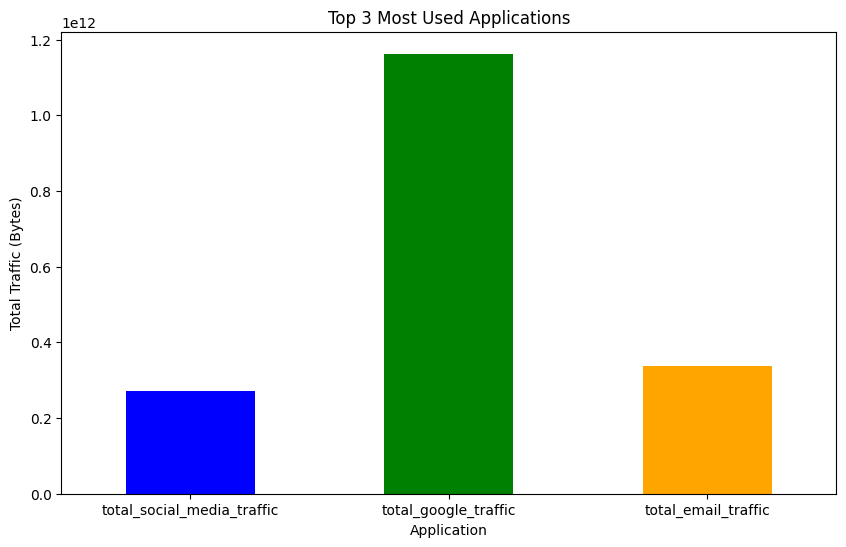

In [20]:
# Prepare data for plotting
app_traffic_totals = app_traffic_per_user[['total_social_media_traffic', 'total_google_traffic', 'total_email_traffic']].sum()

# Plot the top 3 most used applications
plt.figure(figsize=(10, 6))
app_traffic_totals.plot(kind='bar', color=['blue', 'green', 'orange'])
plt.title('Top 3 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Traffic (Bytes)')
plt.xticks(rotation=0)
plt.show()

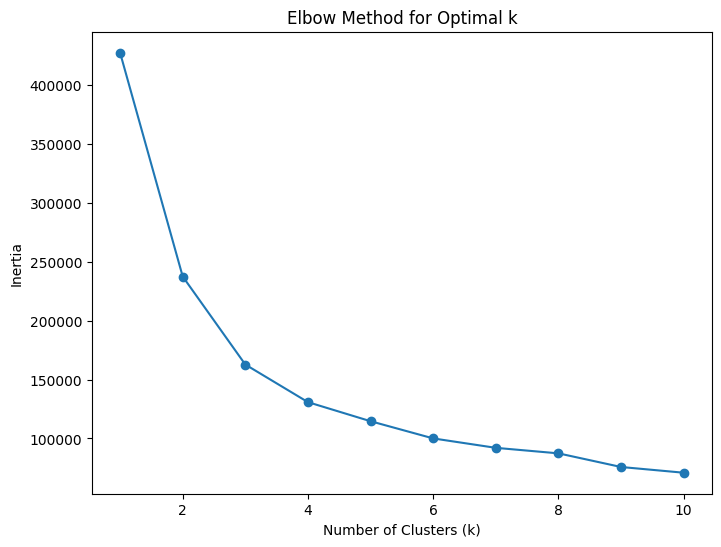

In [21]:
# Elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(engagement_metrics[metrics_to_normalize])
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()